# Image Segmentation U-Net
[https://ithelp.ithome.com.tw/articles/10240314](https://ithelp.ithome.com.tw/articles/10240314)

# Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!tar -xf "/content/drive/MyDrive/Colab Notebooks/annotations.tar.gz" -C /content
!tar -xf "/content/drive/MyDrive/Colab Notebooks/images.tar.gz" -C /content

In [3]:
import os
import tensorflow.keras as keras
import tensorflow as tf
import numpy
import math

DATA_ROOT_DIR = '/content/'
SEED = 2021
IMG_SIZE = (160, 160)
NUM_CLASSES = 4
BATCH_SIZE = 100

os.environ['PYTHONHASHSEED'] = str(SEED)
numpy.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
files = []

for file in os.listdir(DATA_ROOT_DIR + 'images'):
    # file = Abyssinian_1.jpg
    if file.endswith('jpg'):
        fn = file.split('.')[0]
        if os.path.isfile(DATA_ROOT_DIR + 'annotations/trimaps/' + fn + '.png'):
            files.append(fn)
files = sorted(files)

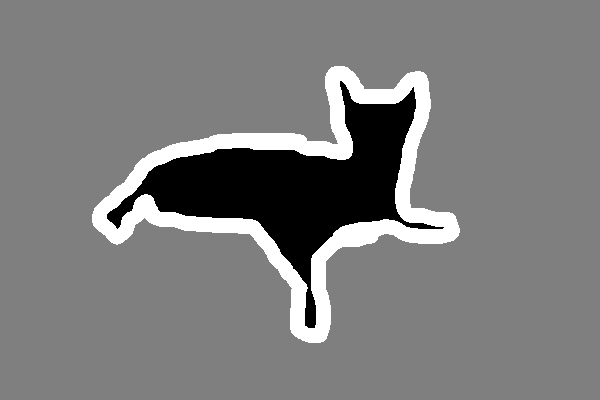

In [5]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# ImageOps.autocontrast() method maximizes (normalize) image contrast. 
# This function calculates a histogram of the input image, 
# removes cutoff percent of the lightest and darkest pixels from the histogram, 
# and remaps the image so that the darkest pixel becomes black (0), 
# and the lightest becomes white (255).

img = PIL.ImageOps.autocontrast(load_img(DATA_ROOT_DIR + 'annotations/trimaps/' + files[0] + '.png'))
display(img)

## Data Generator

In [6]:
# reference: https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
class OxfordPets(keras.utils.Sequence):
    def __init__(self, files):
        self.files = files
    def __len__(self):
        return math.ceil(len(self.files) / BATCH_SIZE)
    def __getitem__(self, index):
        x, y = [], []
        for i in range(index * BATCH_SIZE, min((index+1) * BATCH_SIZE, len(self.files))):
            # target size in load_img
            # (img_height, img_width)
            x.append(numpy.array(load_img(DATA_ROOT_DIR + 'images/' + self.files[i] + '.jpg', target_size = IMG_SIZE), dtype='float32'))
            y.append(numpy.array(load_img(DATA_ROOT_DIR + 'annotations/trimaps/' + self.files[i] + '.png', target_size = IMG_SIZE, color_mode="grayscale"), dtype='uint8'))

        return numpy.array(x), numpy.array(y)


## U-Net

In [7]:
def model(imgSize, outputSize):
    inputs = keras.Input(shape=imgSize+(3,))

    # ENCODING
    x = keras.layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x2 = x

    for filter in [64, 128, 256]:
        x = keras.layers.ReLU()(x)
        x = keras.layers.SeparableConv2D(filter, 3, padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
        x = keras.layers.SeparableConv2D(filter, 3, padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Residual
        x2 = keras.layers.Conv2D(filter, 1, strides=2, padding='same')(x2)

        x = keras.layers.add([x, x2])
        x2 = x
    
    # DECODING
    for filter in [256, 128, 64, 32]:
        x = keras.layers.ReLU()(x)
        x = keras.layers.Conv2DTranspose(filter, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.ReLU()(x)
        x = keras.layers.Conv2DTranspose(filter, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)
        
        # Residual
        x2 = keras.layers.UpSampling2D(2)(x2)
        x2 = keras.layers.Conv2D(filter, 1, padding='same')(x2)

        x = keras.layers.add([x, x2])
        x2 = x
    
    outputs = keras.layers.Conv2D(outputSize, 3, activation='softmax', padding='same')(x)
    return keras.Model(inputs, outputs)

# Free up RAM in case the model definition celss we run multiple times
keras.backend.clear_session()

## Start Training!

In [8]:
m = model(IMG_SIZE, NUM_CLASSES)
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
numpy.random.shuffle(files)
middle = math.ceil(len(files) * 0.8)
train = OxfordPets(files[:middle])
test = OxfordPets(files[middle:])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

m.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
history = m.fit(train, validation_data=test, epochs=50, callbacks=callbacks)

Epoch 1/50
60/60 [==============================] - 92s 875ms/step - loss: 1.6479 - val_loss: 1.1014


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
60/60 [==============================] - 50s 826ms/step - loss: 0.7539 - val_loss: 1.4922
Epoch 3/50
60/60 [==============================] - 50s 826ms/step - loss: 0.6081 - val_loss: 1.3323
Epoch 4/50
60/60 [==============================] - 50s 829ms/step - loss: 0.5278 - val_loss: 1.4379
Epoch 5/50
60/60 [==============================] - 50s 821ms/step - loss: 0.4792 - val_loss: 2.5049
Epoch 6/50
60/60 [==============================] - 50s 830ms/step - loss: 0.4328 - val_loss: 2.3510
Epoch 7/50
60/60 [==============================] - 50s 827ms/step - loss: 0.4111 - val_loss: 2.5693
Epoch 8/50
60/60 [==============================] - 49s 812ms/step - loss: 0.3837 - val_loss: 1.2486
Epoch 9/50
60/60 [==============================] - 51s 845ms/step - loss: 0.3642 - val_loss: 0.7243
Epoch 10/50
60/60 [==============================] - 49s 817ms/step - loss: 0.3396 - val_loss: 0.4179
Epoch 11/50
60/60 [==============================] - 49s 820ms/step - loss: 0.3182 - val_l

# Evaluate

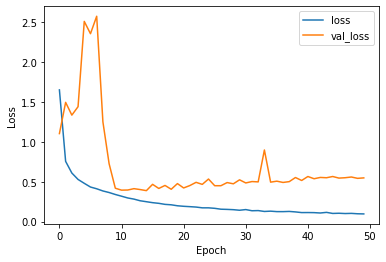

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [11]:
def mask_to_img(predict):
    mask = numpy.argmax(predict, axis=-1)
    # numpy.expand_dims() expand the shape of an array.
    # Insert a new axis that will appear at the axis position in the expanded
    # array shape.
    mask = numpy.expand_dims(mask, axis = -1)
    return PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))

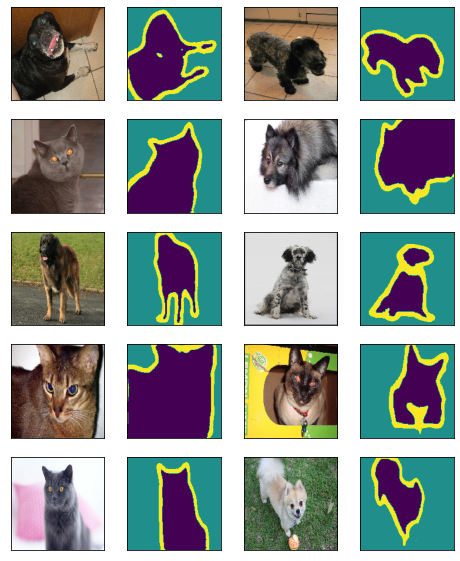

In [12]:
demo_data = OxfordPets(files[:10])
demo_res = m.predict(demo_data)

plt.figure(figsize=(8, 10))
for i in range(10):
    plt.subplot(5, 4, i*2+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(keras.preprocessing.image.array_to_img(demo_data.__getitem__(0)[0][i]))
    plt.subplot(5, 4, i*2+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask_to_img(demo_res[i]))

plt.show()
plt.close()